In [46]:
import networkx as nx
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name'
                    'landuse', 'width', 'est_width', 'junction', 'surface']
ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    # cf = '["highway"~"motorway|motorway_link"]'
    # cf = '["highway"~"primary"]'  # orange roads OSM viewer
    # cf = '["highway"~"motorway|motorway_link|primary|secondary"]'
    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential"]'

    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
    # G = ox.graph_from_address('Emmerich, Germany', dist=10000, simplify=True, custom_filter=cf)
    G = ox.graph_from_address('Winterswijk, Netherlands', dist=10000, network_type='drive', simplify=False, custom_filter=cf)
     
    # G = ox.graph_from_point((6.6748121, 51.9511542), dist=1000, network_type='drive', simplify=True)
    # G = ox.graph_from_place('Almelo, Netherlands', network_type='drive', simplify=True, custom_filter=cf)

    # default speeds
    hwy_speeds = {'motorway': 100,
                    'trunk': 100,
                    'residential': 30,
                    'tertiary': 30} #etc

    G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G, precision=1)

    return G

In [11]:
def save_graph(G):
    filepath=f"graphs/Winterswijk.graph.graphml"
    # ox.save_graph_geopackage(G, filepath=filepath)
    ox.save_graphml(G,filepath)

In [12]:
def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['silver'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [47]:
# city = ("")
# distance = 2400
#
G=generate_streetnetwork()
# save_graph(G, city, distance)
#
print(len(G.nodes()))

# show_graph(city, distance)

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_17312\1602027044.py:50: UserWarning: the `precision` parameter is deprecated and will be removed in a future release
  G = ox.add_edge_travel_times(G, precision=1)


19023


In [14]:
for u,v,data in G.edges(data=True):
    if 'surface' in list(G[u][v][0].keys()):
        if G[u][v][0]['surface'] == 'unpaved':
            print(G[u][v][0]['speed_kph'])
            G[u][v][0]['speed_kph'] = 20

In [15]:
# save_graph(G)

In [7]:
def show_graph():
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 6.715503611053481, 51.97037617480607)  # bank

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('red')
        else:
            node_size.append(0)
            node_color.append('silver')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/prelim_Winterwijk.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

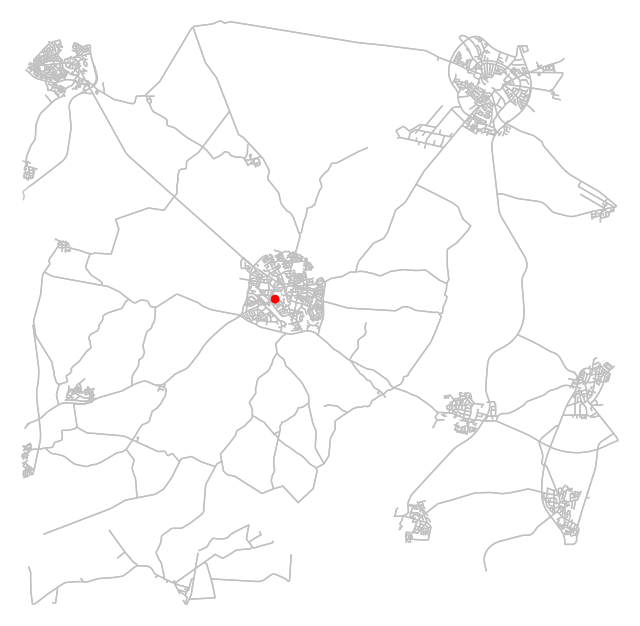

In [8]:
show_graph()

## Find border nodes

In [16]:
import geopandas as gpd
import shapely

filepath=f"graphs/Winterswijk.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [48]:
nodes_gdf, streets = ox.graph_to_gdfs(G, nodes=True, edges=True,
                            node_geometry=False, fill_edge_geometry=True)
streets = streets.to_crs(4326)
streets

osmid      highway  oneway  reversed   length  \
u           v          key                                                     
18278659    18278660   0    37585575  residential   False     False   22.536   
18278660    18278661   0    37585575  residential   False     False   10.232   
            18278659   0    37585575  residential   False      True   22.536   
18278661    520515385  0    37585573  residential   False     False   32.571   
            18278660   0    37585575  residential   False      True   10.232   
...                              ...          ...     ...       ...      ...   
11516190841 365688331  0    32520141  residential   False      True    6.913   
11516190842 552401909  0    43662382  residential   False     False    3.881   
            552401904  0    43662382  residential   False      True  113.486   
11516190845 4023341909 0    46843313     tertiary   False     False   30.862   
            552401909  0    46843313     tertiary   False      True  115.797   

                            speed_kph  travel_time               name  \
u           v          key                                              
18278659    18278660   0         30.0          2.7                NaN   
18278660    18278661   0         30.0          1.2                NaN   
            18278659   0         30.0          2.7                NaN   
18278661    520515385  0         30.0          3.9        Vennebülten   
            18278660   0         30.0          1.2                NaN   
...                               ...          ...                ...   
11516190841 365688331  0         30.0          0.8           Heideweg   
11516190842 552401909  0         30.0          0.5        Ostlandring   
            552401904  0         30.0         13.6        Ostlandring   
11516190845 4023341909 0         50.0          2.2  Eichendorffstraße   
            552401909  0         50.0          8.3  Eichendorffstraße   

                            surface lanes maxspeed   ref bridge junction  \
u           v          key                                                 
18278659    18278660   0        NaN   NaN      NaN   NaN    NaN      NaN   
18278660    18278661   0        NaN   NaN      NaN   NaN    NaN      NaN   
            18278659   0        NaN   NaN      NaN   NaN    NaN      NaN   
18278661    520515385  0    asphalt   NaN      NaN   NaN    NaN      NaN   
            18278660   0        NaN   NaN      NaN   NaN    NaN      NaN   
...                             ...   ...      ...   ...    ...      ...   
11516190841 365688331  0        NaN   NaN       30   NaN    NaN      NaN   
11516190842 552401909  0        NaN   NaN       30   NaN    NaN      NaN   
            552401904  0        NaN   NaN       30   NaN    NaN      NaN   
11516190845 4023341909 0        NaN   NaN       50  K 20    NaN      NaN   
            552401909  0        NaN   NaN       50  K 20    NaN      NaN   

                           access service tunnel area width  \
u           v          key                                    
18278659    18278660   0      NaN     NaN    NaN  NaN   NaN   
18278660    18278661   0      NaN     NaN    NaN  NaN   NaN   
            18278659   0      NaN     NaN    NaN  NaN   NaN   
18278661    520515385  0      NaN     NaN    NaN  NaN   NaN   
            18278660   0      NaN     NaN    NaN  NaN   NaN   
...                           ...     ...    ...  ...   ...   
11516190841 365688331  0      NaN     NaN    NaN  NaN   NaN   
11516190842 552401909  0      NaN     NaN    NaN  NaN   NaN   
            552401904  0      NaN     NaN    NaN  NaN   NaN   
11516190845 4023341909 0      NaN     NaN    NaN  NaN   NaN   
            552401909  0      NaN     NaN    NaN  NaN   NaN   

                                                                   geometry  
u           v          key                                                   
18278659    18278660   0    LINESTRING (6.77393 51.90506, 6.77418 51.90520)

In [49]:
# import geopackage file in geopandas
nld = gpd.read_file("geodata/BestuurlijkeGebieden_2023.gpkg", layer=1)
# nld = gpd.read_file("graphs/FLEE/Netherlands_shapefile/nl_1km.shp")
nld = nld.to_crs(4326)
nld

,identificatie,naam,code,geometry
0,LND6030,Nederland,6030,"MULTIPOLYGON (((4.87125 51.41135, 4.87185 51.4..."


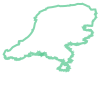

In [50]:
multiLines = shapely.geometry.MultiLineString([x.exterior for x in nld.geometry[0].geoms])
multiLines

In [51]:
lines = streets.geometry.unary_union
intersection = lines.intersection(nld.geometry[0])
# [p for p in intersection.geoms]
type(intersection)

shapely.geometry.multilinestring.MultiLineString

In [52]:
intersectionn = gpd.sjoin(streets, nld)

<Axes: >

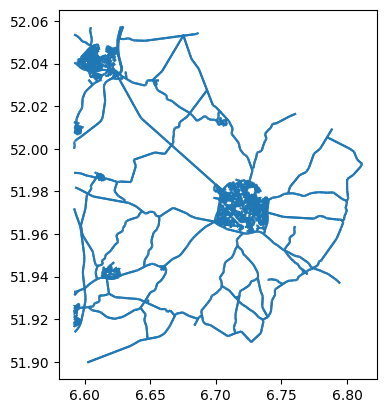

In [53]:
intersectionn.plot()

In [54]:
intersectionn

osmid      highway  oneway  reversed   length  \
u           v           key                                                    
44307032    44311233    0    6697859     tertiary   False      True  299.465   
44311233    44307032    0    6697859     tertiary   False     False  299.465   
            10055816522 0    6697899     tertiary   False     False  431.496   
44322095    44324796    0    6697899     tertiary   False     False  209.357   
            10055816522 0    6697899     tertiary   False      True  430.787   
...                              ...          ...     ...       ...      ...   
11491020929 44953168    0    6690486  residential   False      True    5.652   
11491020930 11491020916 0    6690486  residential   False     False   11.126   
            44953144    0    6690486  residential   False      True    8.531   
11491020931 44951385    0    6690486  residential   False     False   18.133   
            44951060    0    6690486  residential   False      True    6.187   

                             speed_kph  travel_time                 name  \
u           v           key                                                
44307032    44311233    0         60.0         18.0  Driehonderdmeterweg   
44311233    44307032    0         60.0         18.0  Driehonderdmeterweg   
            10055816522 0         60.0         25.9  Driehonderdmeterweg   
44322095    44324796    0         60.0         12.6  Driehonderdmeterweg   
            10055816522 0         60.0         25.8  Driehonderdmeterweg   
...                                ...          ...                  ...   
11491020929 44953168    0         30.0          0.7            De Bempte   
11491020930 11491020916 0         30.0          1.3            De Bempte   
            44953144    0         30.0          1.0            De Bempte   
11491020931 44951385    0         30.0          2.2            De Bempte   
            44951060    0         30.0          0.7            De Bempte   

                             surface lanes  ... access service tunnel area  \
u           v           key                 ...                              
44307032    44311233    0    asphalt   NaN  ...    NaN     NaN    NaN  NaN   
44311233    44307032    0    asphalt   NaN  ...    NaN     NaN    NaN  NaN   
            10055816522 0    asphalt   NaN  ...    NaN     NaN    NaN  NaN   
44322095    44324796    0    asphalt   NaN  ...    NaN     NaN    NaN  NaN   
            10055816522 0    asphalt   NaN  ...    NaN     NaN    NaN  NaN   
...                              ...   ...  ...    ...     ...    ...  ...   
11491020929 44953168    0        NaN   NaN  ...    NaN     NaN    NaN  NaN   
11491020930 11491020916 0        NaN   NaN  ...    NaN     NaN    NaN  NaN   
            44953144    0        NaN   NaN  ...    NaN     NaN    NaN  NaN   
11491020931 44951385    0        NaN   NaN  ...    NaN     NaN    NaN  NaN   
            44951060    0        NaN   NaN  ...    NaN     NaN    NaN  NaN   

                            width  \
u           v           key         
44307032    44311233    0     NaN   
44311233    44307032    0     NaN   
            10055816522 0     NaN   
44322095    44324796    0     NaN   
            10055816522 0     NaN   
...                           ...   
11491020929 44953168    0     NaN   
11491020930 11491020916 0     NaN   
            44953144    0     NaN   
11491020931 44951385    0     NaN   
            44951060    0     NaN   

                                                                    geometry  \
u           v           key                                                    
44307032    44311233    0    LINESTRING (6.60213 51.89971, 6.60621 51.90067)   
44311233    44307032    0    LINESTRING (6.60621 51.90067, 6.60213 51.89971)   
            10055816522 0    LINESTRING (6.60621 51.90067, 6.61208 51.90206)   
44322095    44324796    0    LINESTRING (6.61795 51.90344, 6.62080 51.90412)   
            10055816522 

In [55]:
unique_osmids_u = list(intersectionn.index.unique(level=0))
unique_osmids_v = list(intersectionn.index.unique(level=1))
unique_osmids = list(set(unique_osmids_u) | set(unique_osmids_v))
# nodes_gdf.iloc[unique_osmids]
nodes_gdf_intersection = nodes_gdf[nodes_gdf.index.isin(unique_osmids)]

In [56]:
len(unique_osmids)

9540

In [57]:
nodes_gdf_intersection

,y,x,street_count,highway,ref
osmid,,,,,
44307032,51.899707,6.602135,1,NaN,NaN
44311233,51.900675,6.606208,2,NaN,NaN
44322095,51.903441,6.617949,2,NaN,NaN
44324796,51.904117,6.620797,2,NaN,NaN
44326073,51.904440,6.622150,2,NaN,NaN
...,...,...,...,...,...
11491020916,52.035100,6.618598,2,NaN,NaN
11491020921,52.035864,6.618717,2,NaN,NaN
11491020929,52.035050,6.619426,2,NaN,NaN


In [58]:
G_intersection = ox.graph_from_gdfs(nodes_gdf_intersection, intersectionn)

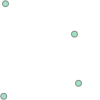

In [59]:
border_crossings = streets.geometry.unary_union.intersection(multiLines)  # streets.intersection(multiLines)
border_crossings

In [60]:
N_subs=1 #Number of biggest islands you want to keep
G_sub=[]
largest_components=[]
for i in range(N_subs):
  largest_components.append(sorted(nx.weakly_connected_components(G_intersection), key=len, reverse=True)[i])
  G_sub.append(G_intersection.subgraph(largest_components[i]))
  
G_cc=nx.compose_all(G_sub)

In [61]:
len(G_cc.nodes)

9540

    ## Construct locations.csv

In [23]:
border_nodes = []
for point in border_crossings.geoms:
    node = ox.nearest_nodes(G_cc, point.x, point.y)
    border_nodes.append(node)

In [24]:
def show_graph_camp(G, border_nodes, cameras):
    edge_colormap, edge_weightmap = draw_edges(G)

    node_size = []
    node_color = []
    
    suspect_start = ox.nearest_nodes(G, 6.715503611053481, 51.97037617480607)  # bank
    
    with open(f'data/optimization/start_police_Winterswijk.pkl', 'rb') as f:
        police_start = pickle.load(f)
    
    for node, data in G.nodes(data=True):
        if node == suspect_start: 
            node_size.append(80)
            node_color.append('tab:orange')
        elif node in border_nodes:
        # if (round(data['y'], 3) in latlon_y) and (round(data['x'], 3) in latlon_x):
        #     print(data['y'], data['x'])
            node_size.append(80)
            node_color.append('tab:red')
        elif node in police_start:
            node_size.append(80)
            node_color.append('tab:blue')
        elif node in cameras:
            node_size.append(20)
            node_color.append('tab:green')     
        else:
            node_size.append(0)
            node_color.append('silver')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                # save=True, filepath='graphs/Winterswijk.png'
                )
    fig.savefig('graphs/Winterswijk.png', bbox_inches='tight', dpi=300)
    plt.show()

In [25]:
def save_graph(G):
    filepath=f"graphs/Winterswijk.graph.graphml"
    # ox.save_graph_geopackage(G, filepath=filepath)
    ox.save_graphml(G,filepath)

save_graph(G_cc)

In [26]:
import pickle

with open('data/escape_nodes_Winterswijk.pkl', 'wb') as f: 
    pickle.dump(border_nodes, f)

    suspect_start = ox.nearest_nodes(G, 6.715503611053481, 51.97037617480607)  # bank
with open('data/fugitive_start_Winterswijk.pkl', 'wb') as f: 
    pickle.dump(suspect_start, f)

In [27]:
cameras_df = pd.read_csv('data/cameraplan.csv')

In [28]:
lats = []
lons = []
for n, data in G.nodes(data=True):
    lats.append(data['y'])
    lons.append(data['x'])
    
lons

[6.7739342,
 6.7743185,
 6.7782606,
 6.7780338,
 6.775957,
 6.7928331,
 6.8044919,
 6.8568483,
 6.8477661,
 6.8576578,
 6.8573864,
 6.8399519,
 6.8411826,
 6.8837934,
 6.8453025,
 6.8178262,
 6.8241191,
 6.8102817,
 6.8642536,
 6.8639046,
 6.8641234,
 6.8586432,
 6.8555342,
 6.8576572,
 6.8542637,
 6.8544019,
 6.8544627,
 6.8543222,
 6.8545594,
 6.8625917,
 6.8605866,
 6.8633673,
 6.778856,
 6.7788357,
 6.6842653,
 6.6807295,
 6.5967244,
 6.7956394,
 6.7919587,
 6.8689484,
 6.8686126,
 6.8686155,
 6.85083,
 6.8538965,
 6.8576023,
 6.6021345,
 6.6480693,
 6.7148223,
 6.592227,
 6.5934771,
 6.5934311,
 6.5931845,
 6.5967371,
 6.5956243,
 6.5948873,
 6.592359,
 6.59526,
 6.595553,
 6.5935,
 6.59322,
 6.59382,
 6.5973469,
 6.59624,
 6.5934077,
 6.7357193,
 6.5936765,
 6.6864226,
 6.59228,
 6.59515,
 6.5921019,
 6.594309,
 6.7396697,
 6.5932291,
 6.592217,
 6.5926839,
 6.5929837,
 6.6688398,
 6.6894505,
 6.668523,
 6.6690403,
 6.5946182,
 6.594504,
 6.5923575,
 6.5934853,
 6.59452,
 6.59385

In [29]:
#delete the cameras that are outside the bounding box
for index, row in cameras_df.iterrows():
    if float(row['Latitude']) < min(lats) or float(row['Latitude']) > max(lats):
        cameras_df = cameras_df.drop(index)
    elif float(row['Longitude']) < min(lons)  or float(row['Longitude']) > max(lons):
        cameras_df = cameras_df.drop(index)

In [30]:
cameras = []
for index, row in cameras_df.iterrows():
    # if row['Tijdigheid camera'] == 'Tijdelijk':
    #     cameras_df = cameras_df.drop(index)
    #     continue
    # if row['Doel van de camera'] != 'Openbare Orde & Veiligheid':
    #     continue
        
    lat = float(row['Latitude'])
    lon = float(row['Longitude'])
    closest_node = ox.nearest_nodes(G, lon, lat)
    cameras.append(closest_node)
    
cameras = list(set(cameras))

In [31]:
cameras

[34820323]

In [32]:
border_nodes

[44398479, 34820323, 45037902, 44821801]

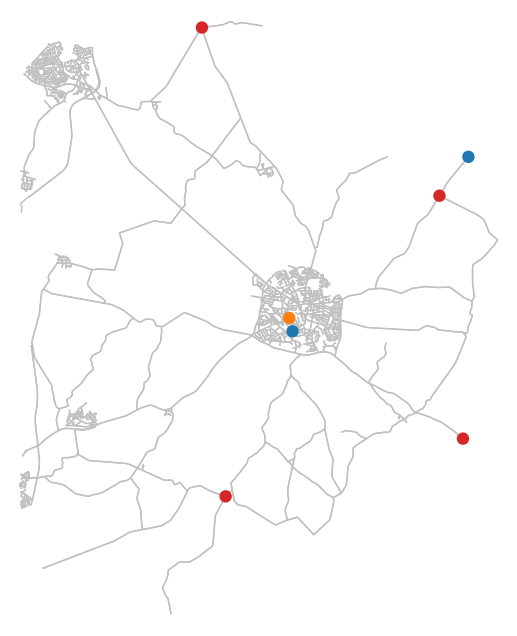

In [33]:
show_graph_camp(G_cc, border_nodes, cameras)

In [34]:
len(G.nodes())

3288

## routes.csv

In [35]:
from collections import defaultdict
routes_dict = defaultdict(list)

for u, v, data in G.edges(data=True):
    #"name1"	name2	distance	forced_redirection
    routes_dict['name1'].append(u)
    routes_dict['name2'].append(v)
    routes_dict['distance'].append(data['travel_time'])
    routes_dict['forced_redirection'].append(0)

routes_df = pd.DataFrame.from_dict(routes_dict, orient='columns')

In [36]:
routes_df.to_csv('graphs/FLEE/routes.csv', index=False)
routes_df

OSError: Cannot save file into a non-existent directory: 'graphs\FLEE'

## conflicts.csv

In [ ]:
ox.nearest_nodes(G, 52.0907, 5.1214)  # Utrecht

In [ ]:
suspect_start = ox.nearest_nodes(G, 5.1214, 52.0907)  # Utrecht}
# columns=['day', 'name', 'node', 'D'])
conflicts_dict = {'Day': [0], 'name': [0], suspect_start: [1]}

In [ ]:
conflicts_df = pd.DataFrame.from_dict(conflicts_dict, orient='columns')

In [ ]:
anpr = pd.read_excel('anpr_camera_locaties.xlsx')
anpr

In [ ]:
anpr_nodes = []
for lat, lon in zip(anpr['latitude'], anpr['longitude']):
    anpr_nodes.append(ox.nearest_nodes(G, lon, lat))

anpr_nodes = list(set(anpr_nodes))

In [ ]:
def show_graph_anpr(G, latlon_y, latlon_x):
    edge_colormap, edge_weightmap = draw_edges(G)

    node_size = []
    node_color = []
    for node, data in G.nodes(data=True):
        if (round(data['y'], 2) in latlon_y) and (round(data['x'], 2) in latlon_x):
            node_size.append(40)
            node_color.append('red')
        elif node in anpr_nodes:
            node_size.append(40)
            node_color.append('tab:green')
        else:
            node_size.append(0)
            node_color.append('silver')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/FLEE/Graph_FLEE_anpr.png'
                )

show_graph_anpr(G_intersection, latlon_y, latlon_x)

In [ ]:
for anpr_node in anpr_nodes:
    conflicts_df[anpr_node] = 0.1

In [ ]:
conflicts_df

In [ ]:
conflicts_df.to_csv('graphs/FLEE/conflicts.csv', index=False)
conflicts_df

## locations.csv

In [ ]:
from collections import defaultdict

locations_dict = defaultdict(list)

suspect_start = ox.nearest_nodes(G, 5.1214, 52.0907)

for node, data in G.nodes(data=True):
    locations_dict['name'].append(node)
    locations_dict['lat'].append(data['y'])
    locations_dict['lon'].append(data['x'])

    # locations_dict['location_type'].append('town')
    locations_dict['region'].append('xyz')
    locations_dict['country'].append('xyz')
    locations_dict['conflict_date'].append(0)
    locations_dict['population'].append(0)

    if round(data['y'], 2) in latlon_y and round(data['x'], 2) in latlon_x:
        locations_dict['location_type'].append('camp')  # border crossing = 'camp'
    elif node == suspect_start:
        locations_dict['location_type'].append('conflict')  # start suspects
    elif node in anpr_nodes:
        locations_dict['location_type'].append('conflict')  # anpr cameras
    else:
        locations_dict['location_type'].append('town')
    # if round(data['x'], 2) in latlon_x:
    #     print(round(data['x'], 2))

locations_df = pd.DataFrame.from_dict(locations_dict, orient='columns')

In [ ]:
locations_df.to_csv('graphs/FLEE/locations.csv', index=False)
locations_df

In [11]:
nodes_gdf

,y,x,street_count,highway,ref
osmid,,,,,
18278659,51.905059,6.773934,1,NaN,NaN
18278661,51.905226,6.774318,3,NaN,NaN
18278666,51.904865,6.778261,3,NaN,NaN
18278671,51.905244,6.778034,3,NaN,NaN
18278680,51.907748,6.775957,1,NaN,NaN
...,...,...,...,...,...
11341609665,51.987877,6.612997,3,NaN,NaN
11382423907,52.039195,6.841536,3,NaN,NaN
11420898984,52.032907,6.626254,3,NaN,NaN


In [12]:
streets

osmid       highway  \
u           v           key                                                    
18278659    18278661    0                             37585575   residential   
18278661    18278680    0                             37585573   residential   
            18278659    0                             37585575   residential   
            18278671    0    [43758688, 1114716480, 536199334]   residential   
18278666    34817318    0                            132309783     secondary   
...                                                        ...           ...   
11382423907 334619105   0                             38379024   residential   
11420898984 7619858210  0                   [6691046, 6691054]       primary   
11420898987 11420898984 0             [1231448144, 1231448143]  primary_link   
            44943530    0             [1231448145, 1231448148]  primary_link   
11420898999 7619858203  0                            815873495       primary   

                             oneway reversed   length  \
u           v           key                             
18278659    18278661    0     False    False   32.768   
18278661    18278680    0     False    False  313.843   
            18278659    0     False     True   32.768   
            18278671    0     False    False  256.988   
18278666    34817318    0     False    False   61.344   
...                             ...      ...      ...   
11382423907 334619105   0     False     True  213.483   
11420898984 7619858210  0      True    False  184.355   
11420898987 11420898984 0      True    False   15.766   
            44943530    0      True    False   12.277   
11420898999 7619858203  0      True    False   58.601   

                                                                      geometry  \
u           v           key                                                      
18278659    18278661    0    LINESTRING (6.77393 51.90506, 6.77418 51.90520...   
18278661    18278680    0    LINESTRING (6.77432 51.90523, 6.77446 51.90551...   
            18278659    0    LINESTRING (6.77432 51.90523, 6.77418 51.90520...   
            18278671    0    LINESTRING (6.77432 51.90523, 6.77437 51.90521...   
18278666    34817318    0    LINESTRING (6.77826 51.90487, 6.77839 51.90500...   
...                                                                        ...   
11382423907 334619105   0    LINESTRING (6.84154 52.03919, 6.84180 52.03919...   
11420898984 7619858210  0    LINESTRING (6.62625 52.03291, 6.62633 52.03281...   
11420898987 11420898984 0    LINESTRING (6.62603 52.03294, 6.62614 52.03292...   
            44943530    0    LINESTRING (6.62603 52.03294, 6.62609 52.03297...   
11420898999 7619858203  0    LINESTRING (6.62621 52.03309, 6.62614 52.03317...   

                             speed_kph  travel_time              name  \
u           v           key                                             
18278659    18278661    0         30.0          3.9               NaN   
18278661    18278680    0         30.0         37.7       Vennebülten   
            18278659    0         30.0          3.9               NaN   
            18278671    0         30.0         30.8           Vennweg   
18278666    34817318    0         50.0          4.4     Rheder Straße   
...                                ...          ...               ...   
11382423907 334619105   0         30.0         25.6   Wendfelder Damm   
11420898984 7619858210  0         80.0          8.3  Winterswijkseweg   
11420898987 11420898984 0         80.0          0.7               NaN   
            44943530    0         80.0          0.6               NaN   
11420898999 7619858203  0         80.0          2.6  Winterswijkseweg   

                             surface lanes maxspeed    ref bridge junction  \
u           v           key                                                  
18278659    18278661    0        NaN   NaN      NaN    NaN    NaN      NaN   
18278661    18278680   

In [24]:
G_mergednodes = G.copy()
for node, data in G.nodes(data=True):
    for other_node, other_data in G.nodes(data=True):
        # precieze cutoff even workshoppen
        if (node != other_node) and (abs(data['y'] - other_data['y']) <= 0.00005) and (abs(data['x'] - other_data['x']) <= 0.00005):
            # delete other_node OF node (bepalen obv data, bijv nooit connector houden)
            nx.remove_nodes(node)
            
            for data_edge in G.in_edges(other_node, data=True):
                # verander target in data
                # add edge to network MET  attributen

                # 
            for data_edge in G.out_edges(other_node, data=True):
                # verander source in data
                # add edge to network MET  attributen
                  

44514043 {'y': 51.9423434, 'x': 6.62456, 'street_count': 3} {'y': 51.9422941, 'x': 6.624601, 'street_count': 3}
44522408 {'y': 51.9439692, 'x': 6.7742594, 'street_count': 4} {'y': 51.9439197, 'x': 6.7742208, 'street_count': 4}
44564319 {'y': 51.9523396, 'x': 6.7521625, 'street_count': 4} {'y': 51.9522934, 'x': 6.7521219, 'street_count': 3}
44640449 {'y': 51.9671047, 'x': 6.7267357, 'street_count': 3} {'y': 51.9671486, 'x': 6.7267591, 'street_count': 3}
44644316 {'y': 51.9678205, 'x': 6.7385335, 'street_count': 3} {'y': 51.9678566, 'x': 6.7385349, 'street_count': 3}
44976810 {'y': 52.0397805, 'x': 6.6005931, 'street_count': 3} {'y': 52.039808, 'x': 6.6005472, 'street_count': 3}
80055673 {'y': 52.0402303, 'x': 6.8097203, 'street_count': 3} {'y': 52.0402251, 'x': 6.8097608, 'street_count': 2}
283379848 {'y': 51.9415509, 'x': 6.8704616, 'street_count': 3} {'y': 51.9415611, 'x': 6.8704679, 'street_count': 3}
283653285 {'y': 51.9415611, 'x': 6.8704679, 'street_count': 3} {'y': 51.9415509, 'x

In [28]:
G.edges(data=True)

OutMultiEdgeDataView([(18278659, 18278661, {'osmid': 37585575, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 32.768, 'geometry': <LINESTRING (6.774 51.905, 6.774 51.905, 6.774 51.905)>, 'speed_kph': 30.0, 'travel_time': 3.9}), (18278661, 18278680, {'osmid': 37585573, 'name': 'Vennebülten', 'highway': 'residential', 'surface': 'asphalt', 'oneway': False, 'reversed': False, 'length': 313.843, 'geometry': <LINESTRING (6.774 51.905, 6.774 51.906, 6.775 51.906, 6.775 51.906, 6.775 5...>, 'speed_kph': 30.0, 'travel_time': 37.7}), (18278661, 18278659, {'osmid': 37585575, 'highway': 'residential', 'oneway': False, 'reversed': True, 'length': 32.768, 'geometry': <LINESTRING (6.774 51.905, 6.774 51.905, 6.774 51.905)>, 'speed_kph': 30.0, 'travel_time': 3.9}), (18278661, 18278671, {'osmid': [43758688, 1114716480, 536199334], 'lanes': '1', 'name': 'Vennweg', 'highway': 'residential', 'surface': 'asphalt', 'oneway': False, 'reversed': False, 'length': 256.988, 'maxspeed': 

In [14]:
G[18278661]

AdjacencyView({18278680: {0: {'osmid': 37585573, 'name': 'Vennebülten', 'highway': 'residential', 'surface': 'asphalt', 'oneway': False, 'reversed': False, 'length': 313.843, 'geometry': <LINESTRING (6.774 51.905, 6.774 51.906, 6.775 51.906, 6.775 51.906, 6.775 5...>, 'speed_kph': 30.0, 'travel_time': 37.7}}, 18278659: {0: {'osmid': 37585575, 'highway': 'residential', 'oneway': False, 'reversed': True, 'length': 32.768, 'geometry': <LINESTRING (6.774 51.905, 6.774 51.905, 6.774 51.905)>, 'speed_kph': 30.0, 'travel_time': 3.9}}, 18278671: {0: {'osmid': [43758688, 1114716480, 536199334], 'lanes': '1', 'name': 'Vennweg', 'highway': 'residential', 'surface': 'asphalt', 'oneway': False, 'reversed': False, 'length': 256.988, 'maxspeed': '30', 'geometry': <LINESTRING (6.774 51.905, 6.774 51.905, 6.774 51.905, 6.774 51.905, 6.775 5...>, 'speed_kph': 30.0, 'travel_time': 30.8}}})

In [27]:
list(G.out_edges(18278661, data=True))


[(18278661,
  18278680,
  {'osmid': 37585573,
   'name': 'Vennebülten',
   'highway': 'residential',
   'surface': 'asphalt',
   'oneway': False,
   'reversed': False,
   'length': 313.843,
   'geometry': <LINESTRING (6.774 51.905, 6.774 51.906, 6.775 51.906, 6.775 51.906, 6.775 5...>,
   'speed_kph': 30.0,
   'travel_time': 37.7}),
 (18278661,
  18278659,
  {'osmid': 37585575,
   'highway': 'residential',
   'oneway': False,
   'reversed': True,
   'length': 32.768,
   'geometry': <LINESTRING (6.774 51.905, 6.774 51.905, 6.774 51.905)>,
   'speed_kph': 30.0,
   'travel_time': 3.9}),
 (18278661,
  18278671,
  {'osmid': [43758688, 1114716480, 536199334],
   'lanes': '1',
   'name': 'Vennweg',
   'highway': 'residential',
   'surface': 'asphalt',
   'oneway': False,
   'reversed': False,
   'length': 256.988,
   'maxspeed': '30',
   'geometry': <LINESTRING (6.774 51.905, 6.774 51.905, 6.774 51.905, 6.774 51.905, 6.775 5...>,
   'speed_kph': 30.0,
   'travel_time': 30.8})]

In [16]:
G.in_edges(18278661)

InMultiEdgeDataView([(18278659, 18278661), (18278671, 18278661), (18278680, 18278661)])